In [279]:
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt
from scipy.stats import rankdata 

In [280]:
def FuzzyAHP(matrix, metric):
    """
    Finds the weights of matrix variables based on expert's view . 
    Returns the a dataframe with variables' boundaries, expected values and standard deviation.

    Args:
    matrix: A excel file consists of a quadratic matrix with 4 evaluation metrics (AUC, Accuracy, F1, H-measure) values. 
 
    Returns:
    A ranking of rows.
    df: A dataframe consists of low, medium, high, expected values and standard deviation for every metric.
    df["Exp Val"]: A dataframe containes Expected Value scores of each metric.
    """
    
    n = matrix.shape[1]
    column_names = matrix.columns

    # Define triangular boundaries for five choices 
    fz_dict ={1:[1,1,1],
              2:[1,2,3],
              3:[2,3,4],
              4:[3,4,5],
              5:[4,5,6],
              6:[5,6,7],
              7:[6,7,8],
              8:[7,8,9],
              9:[9,9,9]}

    matrix = matrix.applymap(lambda x: fz_dict[int(x)] if x >= 1 else [round(1/y, 2) for y in sorted(fz_dict[int(1/x)], reverse=True)])
    print(f"Comparison pair-wise matrix {matrix}")
    
    #Fuzzy pairwise matrix of criteria.
    matrix = matrix.values

    # Decompose matrix into three matrices
    low_matrix = np.array([[list(map(float, tup))[0] for tup in row] for row in matrix])
    med_matrix = np.array([[list(map(float, tup))[1] for tup in row] for row in matrix])
    up_matrix = np.array([[list(map(float, tup))[2] for tup in row] for row in matrix])

    # Max eigenvalues of these matrices
    low_eigval = np.max(np.abs(np.linalg.eig(low_matrix)[0]))
    med_eigval = np.max(np.abs(np.linalg.eig(med_matrix)[0]))
    up_eigval = np.max(np.abs(np.linalg.eig(up_matrix)[0]))

    # system of fuzzy linear homogeneous equations
    low_bar_matrix = 2*low_matrix + med_matrix
    med_bar_matrix = low_matrix + 4*med_matrix + up_matrix
    up_bar_matrix = med_matrix + 2*up_matrix

    # Define function for maximum eigen value and vectors.
    def eigenvalue_and_eigenvector(matrix):
    
        matrix =matrix.astype("float")
    
        # Compute the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(matrix)

        # Find the index of the largest eigenvalue
        largest_eigenvalue_index = np.argmax(np.abs(eigenvalues))
        large_eigenvalue = eigenvalues[largest_eigenvalue_index]
    
        # Find the eigenvector corresponding to the largest eigenvalue
        largest_eigenvalue_vector = eigenvectors[:, largest_eigenvalue_index]

        # Normalize the eigenvector
        normalized_eigenvector = largest_eigenvalue_vector / np.linalg.norm(largest_eigenvalue_vector)
        asb_norm_eigvect = np.abs(normalized_eigenvector)
    
        # Print the result
        #print(f"The normalized eigenvector corresponding to the largest eigenvalue is {np.abs(normalized_eigenvector)}")
        #print(f"The largest eigenvalue is {eigenvalues[largest_eigenvalue_index]}")
    
        return large_eigenvalue, asb_norm_eigvect

    # Eigen values and normalized vectors
    low_lambda_max, low_eigvector = eigenvalue_and_eigenvector(low_bar_matrix)
    med_lambda_max, med_eigvector = eigenvalue_and_eigenvector(med_bar_matrix)
    up_lambda_max, up_eigvector = eigenvalue_and_eigenvector(up_bar_matrix)
  
    # eigen vectors bar.
    low_w_bar = [(wi*low_eigval)/(sum(low_eigvector)*med_eigval) for wi in low_eigvector]
    med_w_bar = [(wi)/(sum(med_eigvector)) for wi in med_eigvector]
    up_w_bar = [(wi*up_eigval)/(sum(up_eigvector)*med_eigval) for wi in up_eigvector]

    # Consistency index
    lambdaMax = round(np.mean([low_eigval, med_eigval, up_eigval]),4)
    CI = (lambdaMax - n)/(n-1)

    # Ratio Indec Table
    # Ratio Index table. T. L. Saaty, The analytical hierarchy process: Planning, priority setting, resource allocation, New York: McGraw-Hill, 1980. 
    nu = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    RI = [0,0,0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49, 1.51, 1.48, 1.56, 1.57, 1.58]
    Ratio_Table = dict(zip(nu, RI))

    # Consistency Ratio
    CR = CI/Ratio_Table[n]
    if CR <= 0.1:
        print(f"The consistency ratio is {round(CR,4)}. So should be claimed that the comparison matrix is consistent.")
    else:
        print(f"The consistency ratio is {round(CR,4)}. So should not be claimed that the comparison matrix is consistent.")

    # Calculate the expected value (fuzzy mean) and standard deviation (fuzzy spread)
    EV = [(low_w_bar[i] + 2*med_w_bar[i] + up_w_bar[i])/4 for i in range(n)]

    # Calculate the standard deviation (fuzzy spread)
    sd = [(1/80*(3*(low_w_bar[i]**2) + 4*(med_w_bar[i]**2) + 3*(up_w_bar[i]**2) - 4*low_w_bar[i]*med_w_bar[i] - 2*low_w_bar[i]*up_w_bar[i] - 4*up_w_bar[i]*med_w_bar[i]))**(1/2) for i in range(4)]

    # Aggregated dataframe
    df = pd.DataFrame({"low":low_w_bar, "Medium":med_w_bar, "Upper":up_w_bar, "Exp Val":EV, "St. dev":sd},
                           index=column_names)
        # Plot the results
    values = df.loc[:,"Exp Val"].values.tolist()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(values)), values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#8b0000'], edgecolor='black', linewidth=1.2)

        # Set the labels for the x-axis ticks
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(['AUC', 'Accuracy', 'F1-scores', 'H-measure'], fontsize=12)

        # Set the y-axis label
    ax.set_ylabel('Fuzzy scores', fontsize=12)

    # Set the title for the plot
    ax.set_title('Fuzzy AHP results plot', fontsize=14, fontweight='bold')

        # Set the axis tick and label font size
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)

        # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

        # Add a grid
    ax.grid(axis='y', linestyle='--')

        # Save plot
    plt.savefig(f'Fuzzy AHP results {metric}.png')
        
        # Show plot
    plt.show()

    return df, df["Exp Val"]

def TOPSIS(raw_df1, weights_df, columns_positive_impact, print_results=True, metric=None):
    """
    Finds the best row of a dataframe based on a list of weights. 
    Returns the a dataframe with ranking of rows , their scores and order. 
    Args:
    raw_df1: A DataFrame with values of interest. 
    weights_df: A list of values representing the view of experts respect to evaluation metrics importance.
    columns_positive_impact: Include in a tuple with columns with positive contribution in model i.e. AUC is + but time is -, writing column index i.e. 0,2, etc
    print_results: A boolean parameter which if True, prints the intermediate and final results. Default value is True.
    metric: The highest metric of weights should be passed, if you want a plot of results
    
    Returns:
    A ranking of rows.
    results: A dataframe consists of Topsis, Separation + and - order.
    Sep.iloc[:,2]: A dataframe containes topsis scores
    plt: A list of row names ranking.
    """
   
    raw_df = raw_df1.copy()
    raw_data = raw_df.values
    weights = weights_df.values.T
    
    # Step 1 - Normalizing the ratings    

    divisors = [np.linalg.norm(raw_data[:, j]) for j in range(len(raw_df.columns))]

    raw_data /= divisors

    columns = ["$X_{%d}$" % j for j in range(len(raw_df.columns))]
    if print_results:
        print(f"The normalized rating array is{pd.DataFrame(data=raw_data, index=raw_df.index.to_list(), columns=columns)}")
    
    # Step 2 - Calculating the Weighted Normalized Ratings
    
    raw_data *= weights
    if print_results:
        print(f"The Weighted Normalized Ratings is {pd.DataFrame(data=raw_data, index=raw_df.index.to_list(), columns=columns)}")
    
    # Step 3 - Identifying PIS ( A∗ ) and NIS ( A− )
    
    # Compute the positive and negative ideal solutions (PIS and NIS)
    benefit_attributes = set(columns_positive_impact)
    a_pos = np.array([np.max(raw_data[:, j]) if j in benefit_attributes else np.min(raw_data[:, j]) for j in range(len(raw_df.columns))])
    a_neg = np.array([np.min(raw_data[:, j]) if j in benefit_attributes else np.max(raw_data[:, j]) for j in range(len(raw_df.columns))])

    if print_results:
        print(f"Positive and Negative Ideal Solutions are illustrated below:\n{pd.DataFrame([a_pos, a_neg], index=['$A^*$', '$A^-$'], columns=columns)}")
    
    # Step 4 and 5 - Calculating Separation Measures and Similarities to PIS
     # calculate sp, sn, and cs
    diff_pos = raw_data - a_pos
    diff_neg = raw_data - a_neg
    sp = np.sqrt(np.sum(diff_pos ** 2, axis=1))
    sn = np.sqrt(np.sum(diff_neg ** 2, axis=1))
    cs = sn / (sp + sn)

    # create DataFrame
    Sep = pd.DataFrame({"$S^*$": sp, "$S^-$": sn, "$C^*$": cs}, index=raw_df.index)
    if print_results:
        print(f"The Separation Measures and Similarities to PIS {Sep}")
    
        # Step 6 - Ranking the candidates/alternatives
    
    results = Sep.apply(lambda col: col.sort_values(ascending=False).index).reset_index(drop=True)
    results.columns = ["$S^*$", "$S^-$", "$C^*$"]

    if print_results:
        print(f"The best candidate/alternative according to C* is {results.loc[0,'$C^*$']}")
        print("The preferences in descending order are: " + ", ".join(results['$C^*$'].tolist()) + ".")
    
    if print_results and metric != None:        
        
    # Plot the results 
        values = cs.tolist()

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(len(values)), values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', linewidth=1.2)

    # Set the labels for the x-axis ticks
        ax.set_xticks(range(len(values)))
        ax.set_xticklabels(['1 Hidden Layer MPL', '2 Hidden Layer MPL', '3 Hidden Layer MPL'], fontsize=12)

        # Set the y-axis label
        ax.set_ylabel('Topsis score', fontsize=12)

        # Set the title for the plot
        ax.set_title('TOPSIS results plot', fontsize=14, fontweight='bold')

    # Set the axis tick and label font size
        plt.rc('xtick', labelsize=12)
        plt.rc('ytick', labelsize=12)

        # Remove the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add a grid      
        ax.grid(axis='y', linestyle='--')

        # Save plot
        plt.savefig(f'TOPSIS results {metric}.png')
        
        # Show plot
        plt.show()
            
    return results, Sep.iloc[:,2], plt

def find_intersection_value(x, list_1, list_2, list_of_interest):
    """
    Finds the intersection points of two lines defined by list_1 and list_2 and a third line defined by list_of_interest.
    Returns the x and y coordinates of each intersection point.

    Args:
    x: A list of x-values represents the interval of analysis 
    list_1: A list of y-values representing the one MLP model.
    list_2: A list of y-values representing the other MLP model.
    list_of_interest: A list of y-values representing the MLP model of interest.

    Returns:
    A tuple containing two tuples, each representing the x and y coordinates of an intersection point.
    """
    
    # Estimate intersection of lists
    def estimate_intersection(list_of_interest, list_x):
        intersection, metric_val, indicator = [], [], []
        for i, val in enumerate(list_x[1:], start=1):
            if (list_x[0] > list_of_interest[0] and val < list_of_interest[i]) or (list_x[0] <= list_of_interest[0] and val > list_of_interest[i]):
                intersection.append(list_of_interest[i-1])
                metric_val.append(x[i-1])
                indicator.append(i-1)
        return intersection, metric_val, indicator

    intersection_with_list1, metric_val_list1, indicator_1 = estimate_intersection(list_of_interest, list_1)
    intersection_with_list2, metric_val_list2, indicator_2 = estimate_intersection(list_of_interest, list_2)
    
    # Now calculate the function of intersection points
    def intersection_function(y1, y2, x1, x2):
        # In function y = ax + b, a estimation will be 
        a = (y2-y1)/(x2 - x1)
        
        # In function y = ax + b, b estimation will be 
        b = y1 - a*x1
        
        return a, b

    # Estimate y and x
    def intersection_points(a1, a2, b1, b2):
        # In function y = ax + b, x estimation will be 
        x = (b1-b2)/(a2 - a1)
        
        # In function y = ax + b, y estimation will be 
        y = a1*x + b1
        
        return [x, y]    
                        
    # Calculate intersection points
    def calculate_intersection_points(lista, intersection_with_list, metric_val_list, indicator_list, density_function):
            if intersection_with_list:
                density_i_j = intersection_function(intersection_with_list[0], intersection_with_list[1], metric_val_list[0], metric_val_list[1])
                density_i = intersection_function(lista[indicator_list[0]], lista[indicator_list[1]], metric_val_list[0], metric_val_list[1])
                intersection_point = intersection_points(density_i_j[0], density_i[0], density_i_j[1], density_i[1])
            else:
                intersection_point = None
            return intersection_point

    # Calculate intersection points for list_1
    intersection_point_1_3 = calculate_intersection_points(list_1, intersection_with_list1, metric_val_list1, indicator_1, intersection_function)

    # Calculate intersection points for list_2
    intersection_point_2_3 = calculate_intersection_points(list_2, intersection_with_list2, metric_val_list2, indicator_2, intersection_function)

    # Print error message if there is no intersection
    if not intersection_point_2_3:
        print("There is no intersection between interest and worst density.")
    if not intersection_point_1_3:
        print("There is no intersection between interest and intermediate density.")
    
    return intersection_point_1_3, intersection_point_2_3
    
def sensitivity_analysis(boundary, metric, df_1, weights, columns_positive_impact):
    """
    Make a sensitivity analysis of the best MLP model metric of interest.
    Returns the interval of analysis, 3 models topsis scores for every value in interval of interest and a plot of results.

    Args:
    boundary: Minimum value of weight minus this value represents the lower boundary of interval and versus the upper
    metric: The metric of interest to assess.
    df: A dataframe contains metric values of each model.
    weights: A list of FAHP values representing the expert opinion.
    columns_positive_impact: Include in a tuple with columns with positive contribution in model i.e. AUC is + but time is -, writing column index i.e. 0,2, etc

    Returns:
    x: the interval of analysis.
    scores_1_HL_MLP: A list of topsis scores for 1 HL MLP model.
    scores_2_HL_MLP: A list of topsis scores for 2 HL MLP model.
    scores_3_HL_MLP: A list of topsis scores for 3 HL MLP model.
    """
    # Copy initial DataFrame
    df = df_1.copy()

    # Define low and high doundary of analysis and its interval
    metric_weight = weights[metric]
    high = min(metric_weight + boundary, 1)
    low = max(metric_weight - boundary, 0) 
    x = np.arange(low,high, 0.05).tolist()
    
    # Find the optimal model
    res = TOPSIS(df, weights,columns_positive_impact=columns_positive_impact,print_results=False, metric= metric)
    
    # Save models' names in a  ascending order
    names_sorted = res[1].sort_values(ascending=False).index.to_list()
    
    # Extract index names to a list
    names = res[1].index.tolist()
    
    # Find topsis scores for every model
    topsis_scores = []

    for i in x:
        weights[metric] = i
        topsis_scores.append(list(map(float, TOPSIS(df, weights, columns_positive_impact=columns_positive_impact, print_results=False, metric=metric)[1])))

    scores_1_HL_MLP, scores_2_HL_MLP, scores_3_HL_MLP = zip(*topsis_scores)

    topsis_dict = {name: scores for name, scores in zip(names, [scores_1_HL_MLP, scores_2_HL_MLP, scores_3_HL_MLP])}

    sensitivity = find_intersection_value(x, topsis_dict[names_sorted[1]],topsis_dict[names_sorted[2]], topsis_dict[names_sorted[0]])

    # Print results of analysis
    if sensitivity!= None:
        for i in range(0,len(sensitivity)):
            if sensitivity[i] != None:
                print(f"For higher values of {sensitivity[i][0]} the {res[0].loc[0,'$C^*$']} is greater than {names_sorted[i+1]}")
            else:
                print(f"The {res[0].loc[0,'$C^*$']} is greater than {names_sorted[i+1]} for every value in range of analysis.")    
    
    # Plot results

    # Scores data
    y1 = scores_1_HL_MLP
    y2 = scores_2_HL_MLP
    y3 = scores_3_HL_MLP

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize = (10, 7))

    # Add vertical lines
    if sensitivity!= None:
        if sensitivity[0]!= None:
            ax.axvline(x=sensitivity[0][0], color='red', linewidth = 2, linestyle ="--")
        if sensitivity[1] != None:
            ax.axvline(x=sensitivity[1][0], color='red', linewidth = 2, linestyle ="--")

    # Plot the lines
    ax.plot(x, y1, label='1 HL MPL model')
    ax.plot(x, y2, label='2 HL MPL model')
    ax.plot(x, y3, label='3 HL MPL model')

    # Add labels and a title
    ax.set_xlabel(f'{metric} weight values')
    ax.set_ylabel('TOPSIS scores', rotation=0, labelpad=20)
    ax.set_title(f'{metric} Sensitivity Plot')

    # Add a legend
    ax.legend()

    # save plot
    plt.savefig(f'{metric} sensitivity analysis.png',  dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close()
    return x, scores_1_HL_MLP, scores_2_HL_MLP, scores_3_HL_MLP

Variables which will be used in FIS are the below metrics:

1． Accuracy

2． Precision

3． Recall

4． F-1 score

5． AUC

6. H-meaure

In this educational example, we use only four variables (metrics) in order to evaluate NN output, AUC, Accuracy, F1 score and H measure.

## Merging the best metrics of each NN model 

In [281]:
#Read metrics of 1st dataset

df_1 = pd.read_csv(r'C:\Users\...\credit_risk_dataset_1_Layer_scores.csv')

rownames = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC', "H-measure"]
df_1["metrics"] = rownames

# Set the index of the DataFrame to the list
df_1.set_index("metrics", inplace=True )

# Prin 5 forst lines of df
df_1

,Tree-structured Parzen Estimator,Random Sampler,Genetic Algorithm,Quasi Monte Carlo
metrics,,,,
Accuracy,0.864930,0.864415,0.866472,0.864415
Precision,0.774862,0.764391,0.767411,0.775453
Recall,0.473019,0.481450,0.492411,0.468803
F1-score,0.587435,0.590792,0.599897,0.584341
AUC,0.718975,0.721792,0.727165,0.717082
H-measure,0.334284,0.337359,0.347785,0.330960


As we can observe, genetic algorithm produces the most dominate metrics, and as a result we will use these score to compare with the others MPL models.

In [282]:
# Keep only Random Sampler
df_1 = df_1.drop(["Random Sampler", "Tree-structured Parzen Estimator", "Quasi Monte Carlo"], axis = 1)
df_1.rename(columns={"Genetic Algorithm": "1 Hidden Layer MPL"}, inplace=True)

# Print df2 
df_1

,1 Hidden Layer MPL
metrics,
Accuracy,0.866472
Precision,0.767411
Recall,0.492411
F1-score,0.599897
AUC,0.727165
H-measure,0.347785


In [283]:
df_2 = pd.read_csv(r'C:\Users\...\credit_risk_dataset_2_Layer_scores.csv')

df_2["metrics"] = rownames

# Set the index of the DataFrame to the list
df_2.set_index("metrics", inplace=True )

# Prin 5 forst lines of df
df_2.head()

,Tree-structured Parzen Estimator,Tree-structured Parzen Estimator.1,Genetic Algorithm,Quasi Monte Carlo
metrics,,,,
Accuracy,0.895955,0.900583,0.904354,0.907439
Precision,0.826381,0.915068,0.931319,0.887290
Recall,0.618044,0.563238,0.571669,0.623946
F1-score,0.707188,0.697286,0.708464,0.732673
AUC,0.792456,0.774949,0.780456,0.801861


As we can observe, Quasi Monte Carlo produces the most dominated metrics, and as a result we will use these score to compare with the others MPL models.

In [284]:
# Keep only Random Sampler
df_2 = df_2.drop(["Tree-structured Parzen Estimator.1", "Genetic Algorithm", "Tree-structured Parzen Estimator"], axis = 1)
df_2.rename(columns={"Quasi Monte Carlo": "2 Hidden Layer MPL"}, inplace=True)

# Print df2 
df_2

,2 Hidden Layer MPL
metrics,
Accuracy,0.907439
Precision,0.887290
Recall,0.623946
F1-score,0.732673
AUC,0.801861
H-measure,0.518255


In [285]:
df_3 = pd.read_csv(r'C:\Users\...\credit_risk_dataset_3_Layer_scores.csv')

df_3["metrics"] = rownames

# Set the index of the DataFrame to the list
df_3.set_index("metrics", inplace=True )

# Prin 5 forst lines of df
df_3


,Tree-structured Parzen Estimator,Random Sampler,Genetic Algorithm,Quasi Monte Carlo
metrics,,,,
Accuracy,0.912239,0.903668,0.906754,0.904011
Precision,0.907005,0.896947,0.873256,0.938375
Recall,0.633221,0.594435,0.633221,0.564924
F1-score,0.745780,0.715010,0.734115,0.705263
AUC,0.808327,0.788504,0.804885,0.777729
H-measure,0.535375,0.491948,0.522100,0.476017


As we can observe, Tree-structured Parzen Estimator produces the most dominated metrics, and as a result we will use these score to compare with the others MPL models. 

In [286]:
# Keep only Random Sampler
df_3 = df_3.drop(["Genetic Algorithm", "Random Sampler", "Quasi Monte Carlo"], axis = 1)
df_3.rename(columns={"Tree-structured Parzen Estimator": "3 Hidden Layer MPL"}, inplace=True)

# Print df3
df_3

,3 Hidden Layer MPL
metrics,
Accuracy,0.912239
Precision,0.907005
Recall,0.633221
F1-score,0.745780
AUC,0.808327
H-measure,0.535375


Now, let's merge the best metrics of each model stucture.


In [287]:
# Merge and create raw data
df_C = pd.concat([df_1,df_2,df_3],axis =1)


# drop preecision and recall
df_C = df_C.drop(['Precision', 'Recall'])

# change the index order
new_index = ['AUC',  'Accuracy', 'F1-score',  "H-measure"]
df_C = df_C.reindex(new_index).transpose()

df_C

metrics,AUC,Accuracy,F1-score,H-measure
1 Hidden Layer MPL,0.727165,0.866472,0.599897,0.347785
2 Hidden Layer MPL,0.801861,0.907439,0.732673,0.518255
3 Hidden Layer MPL,0.808327,0.912239,0.745780,0.535375


# Fuzzy AHP

C:\Users\User\AppData\Local\Temp\ipykernel_14800\96684427.py:4: FutureWarning: convert_float is deprecated and will be removed in a future version.
  df = pd.read_excel(r"C:\Users\...\weight_1.xlsx",


Comparison pair-wise matrix                          AUC           Accuracy          F1-score  H-measure
AUC                [1, 1, 1]          [1, 2, 3]         [2, 3, 4]  [3, 4, 5]
Accuracy    [0.33, 0.5, 1.0]          [1, 1, 1]         [1, 2, 3]  [3, 4, 5]
F1-score   [0.25, 0.33, 0.5]   [0.33, 0.5, 1.0]         [1, 1, 1]  [1, 2, 3]
H-measure  [0.2, 0.25, 0.33]  [0.2, 0.25, 0.33]  [0.33, 0.5, 1.0]  [1, 1, 1]
The consistency ratio is 0.0853. So should be claimed that the comparison matrix is consistent.


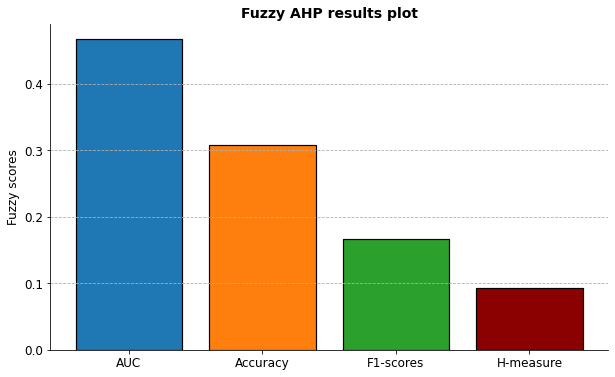

In [288]:
####   AUC   ###

# Import pair-wise comparison table for experts' preferences. 
df = pd.read_excel(r"C:\Users\...\weight_1.xlsx", 
                      convert_float = False,index_col = "Unnamed: 0")  

# Save Fuzzy weights for this case
weights_1 = FuzzyAHP(df, "AUC")[1]

# TOPSIS implementation

Technique for Order Preference by Similarity to Ideal Solution (TOPSIS) came in the 1980s as a multi-criteria-based decision-making method. TOPSIS chooses the alternative of shortest the Euclidean distance from the ideal solution and greatest distance from the negative ideal solution. 

The normalized rating array is                     $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
1 Hidden Layer MPL  0.538251  0.558561  0.497695  0.422945
2 Hidden Layer MPL  0.593541  0.584970  0.607850  0.630255
3 Hidden Layer MPL  0.598327  0.588064  0.618723  0.651074
The Weighted Normalized Ratings is                      $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
1 Hidden Layer MPL  0.251479  0.171801  0.082964  0.039419
2 Hidden Layer MPL  0.277312  0.179923  0.101326  0.058741
3 Hidden Layer MPL  0.279548  0.180875  0.103139  0.060681
Positive and Negative Ideal Solutions are illustrated below:
        $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
$A^*$  0.279548  0.180875  0.103139  0.060681
$A^-$  0.251479  0.171801  0.082964  0.039419
The Separation Measures and Similarities to PIS                        $S^*$     $S^-$     $C^*$
1 Hidden Layer MPL  0.041585  0.000000  0.000000
2 Hidden Layer MPL  0.003600  0.037997  0.913466
3 Hidden Layer MPL  0.000000  0.041585  1.000000
The best candidate/a

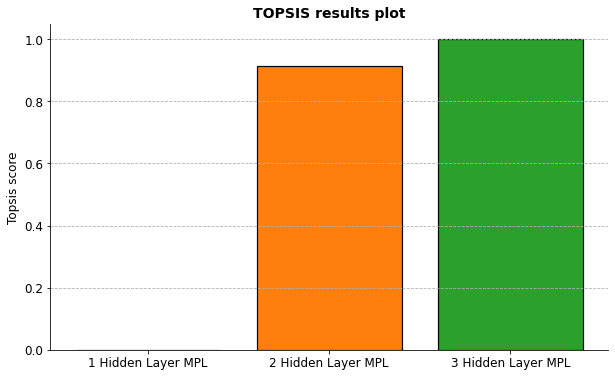

In [290]:
# Use TOPSIS to find the ideal solution in this case.
res = TOPSIS(df_C, weights_1,columns_positive_impact=(0,1,2,3), print_results=True, metric="AUC")

As we observe 3 Hidden Layer MPL is the best model.

There is no intersection between interest and worst density.
There is no intersection between interest and intermediate density.
The 3 Hidden Layer MPL is greater than 2 Hidden Layer MPL for every value in range of analysis.
The 3 Hidden Layer MPL is greater than 1 Hidden Layer MPL for every value in range of analysis.


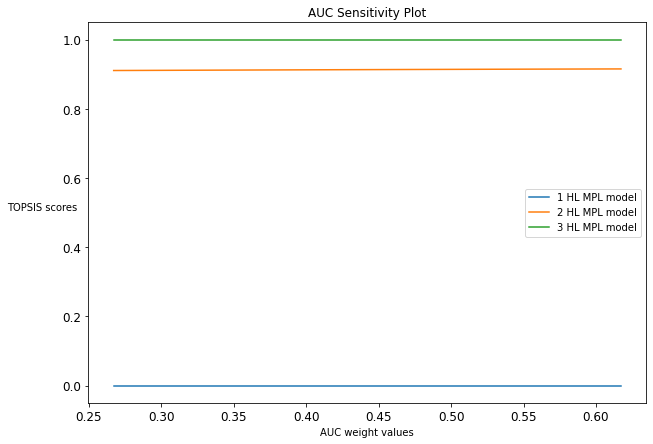

In [274]:
# Sensitivity analysis of AUC weights
scores = sensitivity_analysis(boundary = 0.2, metric = "AUC", df_1= df_C, weights = weights_1,columns_positive_impact=(0,1,2,3))

C:\Users\User\AppData\Local\Temp\ipykernel_14800\3555852603.py:5: FutureWarning: convert_float is deprecated and will be removed in a future version.
  df = pd.read_excel(r"C:\Users\...\weight_2.xlsx",


Comparison pair-wise matrix                          AUC           Accuracy           F1-score  H-measure
AUC                [1, 1, 1]   [0.33, 0.5, 1.0]   [0.33, 0.5, 1.0]  [2, 3, 4]
Accuracy           [1, 2, 3]          [1, 1, 1]   [0.33, 0.5, 1.0]  [3, 4, 5]
F1-score           [1, 2, 3]          [1, 2, 3]          [1, 1, 1]  [3, 4, 5]
H-measure  [0.25, 0.33, 0.5]  [0.2, 0.25, 0.33]  [0.2, 0.25, 0.33]  [1, 1, 1]
The consistency ratio is 0.0975. So should be claimed that the comparison matrix is consistent.


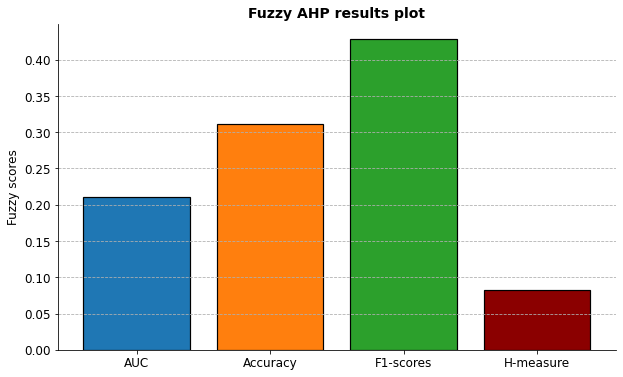

The normalized rating array is                     $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
1 Hidden Layer MPL  0.538251  0.558561  0.497695  0.422945
2 Hidden Layer MPL  0.593541  0.584970  0.607850  0.630255
3 Hidden Layer MPL  0.598327  0.588064  0.618723  0.651074
The Weighted Normalized Ratings is                      $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
1 Hidden Layer MPL  0.113716  0.174239  0.213176  0.034802
2 Hidden Layer MPL  0.125397  0.182477  0.260359  0.051860
3 Hidden Layer MPL  0.126408  0.183442  0.265016  0.053573
Positive and Negative Ideal Solutions are illustrated below:
        $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
$A^*$  0.126408  0.183442  0.265016  0.053573
$A^-$  0.113716  0.174239  0.213176  0.034802
The Separation Measures and Similarities to PIS                        $S^*$     $S^-$     $C^*$
1 Hidden Layer MPL  0.057320  0.000000  0.000000
2 Hidden Layer MPL  0.005156  0.052168  0.910062
3 Hidden Layer MPL  0.000000  0.057320  1.000000
The best candidate/a

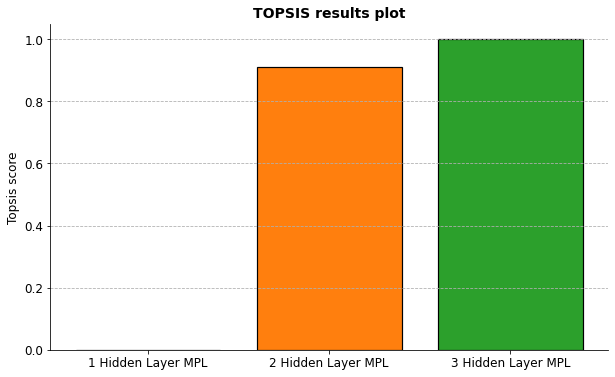

There is no intersection between interest and worst density.
There is no intersection between interest and intermediate density.
The 3 Hidden Layer MPL is greater than 1 Hidden Layer MPL for every value in range of analysis.
The 3 Hidden Layer MPL is greater than 1 Hidden Layer MPL for every value in range of analysis.


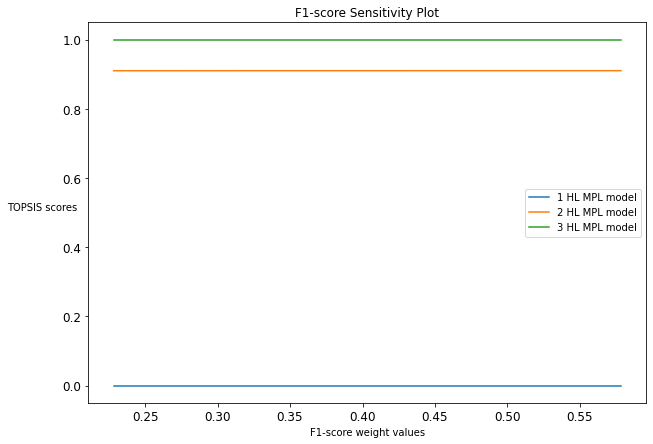

In [259]:
####   F1 score   ###

# Import pair-wise comparison table for experts' preferences. 
df = pd.read_excel(r"C:\Users\...\weight_2.xlsx",
                      convert_float = False,index_col = "Unnamed: 0")  

# Save Fuzzy weights for this case
weights_2 = FuzzyAHP(df, "F1-score")[1]

# Use TOPSIS to find the ideal solution in this case.
res = TOPSIS(df_C, weights_2, columns_positive_impact=(0,1,2,3), print_results=True, metric="F1-score")

# Sensitivity analysis of AUC
scores = sensitivity_analysis(boundary = 0.2, metric = "F1-score", df_1= df_C, weights = weights_2, columns_positive_impact=(0,1,2,3))

Comparison pair-wise matrix                         AUC   Accuracy          F1-score          H-measure
AUC               [1, 1, 1]  [1, 2, 3]         [1, 2, 3]  [0.2, 0.25, 0.33]
Accuracy   [0.33, 0.5, 1.0]  [1, 1, 1]  [0.33, 0.5, 1.0]  [0.17, 0.2, 0.25]
F1-score   [0.33, 0.5, 1.0]  [1, 2, 3]         [1, 1, 1]  [0.17, 0.2, 0.25]
H-measure         [3, 4, 5]  [4, 5, 6]         [4, 5, 6]          [1, 1, 1]
The consistency ratio is 0.097. So should be claimed that the comparison matrix is consistent.


C:\Users\User\AppData\Local\Temp\ipykernel_14800\4103504630.py:4: FutureWarning: convert_float is deprecated and will be removed in a future version.
  df = pd.read_excel(r"C:\Users\...\Fuzzy AHP\weight_3.xlsx",


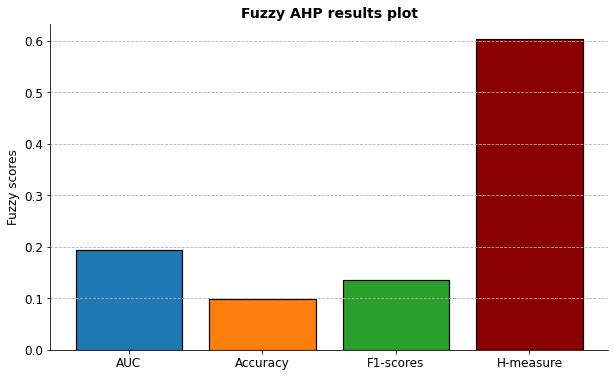

The normalized rating array is                     $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
1 Hidden Layer MPL  0.538251  0.558561  0.497695  0.422945
2 Hidden Layer MPL  0.593541  0.584970  0.607850  0.630255
3 Hidden Layer MPL  0.598327  0.588064  0.618723  0.651074
The Weighted Normalized Ratings is                      $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
1 Hidden Layer MPL  0.104705  0.055130  0.067463  0.255060
2 Hidden Layer MPL  0.115460  0.057737  0.082395  0.380080
3 Hidden Layer MPL  0.116392  0.058042  0.083869  0.392635
Positive and Negative Ideal Solutions are illustrated below:
        $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
$A^*$  0.116392  0.058042  0.083869  0.392635
$A^-$  0.104705  0.055130  0.067463  0.255060
The Separation Measures and Similarities to PIS                        $S^*$     $S^-$    $C^*$
1 Hidden Layer MPL  0.139072  0.000000  0.00000
2 Hidden Layer MPL  0.012679  0.126394  0.90883
3 Hidden Layer MPL  0.000000  0.139072  1.00000
The best candidate/alter

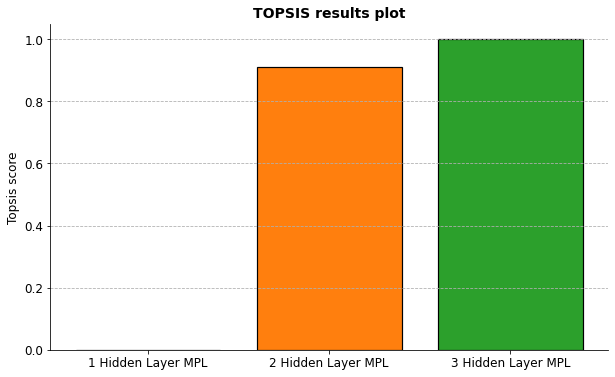

There is no intersection between interest and worst density.
There is no intersection between interest and intermediate density.
The 3 Hidden Layer MPL is greater than 2 Hidden Layer MPL for every value in range of analysis.
The 3 Hidden Layer MPL is greater than 1 Hidden Layer MPL for every value in range of analysis.


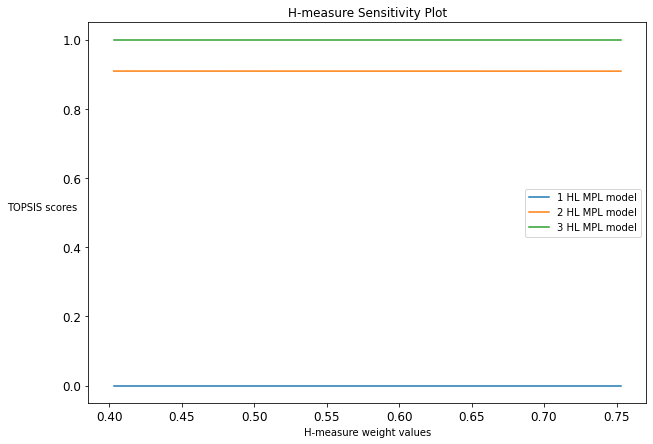

In [275]:
####   H-measure   ###

# Import pair-wise comparison table for experts' preferences. 
df = pd.read_excel(r"C:\Users\...\weight_3.xlsx",
                      convert_float = False,index_col = "Unnamed: 0")  

# Save Fuzzy weights for this case
weights_3 = FuzzyAHP(df, "H-measure")[1]

# Use TOPSIS to find the ideal solution in this case.
res = TOPSIS(df_C, weights_3, columns_positive_impact=(0,1,2,3), print_results=True, metric="H-measure")

# Sensitivity analysis of AUC
scores = sensitivity_analysis(boundary = 0.2, metric = "H-measure", df_1= df_C, weights = weights_3, columns_positive_impact=(0,1,2,3))

Comparison pair-wise matrix                          AUC           Accuracy          F1-score  H-measure
AUC                [1, 1, 1]  [0.2, 0.25, 0.33]         [1, 2, 3]  [2, 3, 4]
Accuracy           [3, 4, 5]          [1, 1, 1]         [2, 3, 4]  [4, 5, 6]
F1-score    [0.33, 0.5, 1.0]  [0.25, 0.33, 0.5]         [1, 1, 1]  [1, 2, 3]
H-measure  [0.25, 0.33, 0.5]  [0.17, 0.2, 0.25]  [0.33, 0.5, 1.0]  [1, 1, 1]
The consistency ratio is 0.0997. So should be claimed that the comparison matrix is consistent.


C:\Users\User\AppData\Local\Temp\ipykernel_14800\3916066927.py:4: FutureWarning: convert_float is deprecated and will be removed in a future version.
  df = pd.read_excel(r"C:\Users\...\weight_4.xlsx",


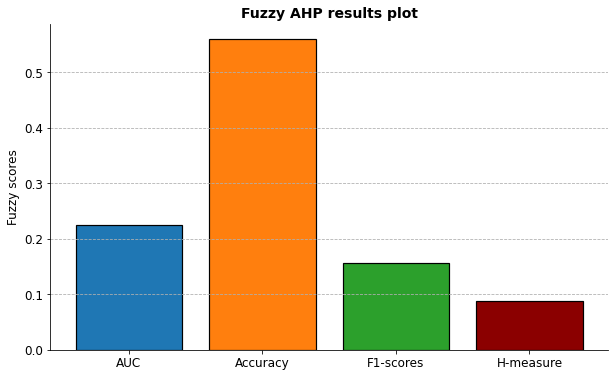

The normalized rating array is                     $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
1 Hidden Layer MPL  0.538251  0.558561  0.497695  0.422945
2 Hidden Layer MPL  0.593541  0.584970  0.607850  0.630255
3 Hidden Layer MPL  0.598327  0.588064  0.618723  0.651074
The Weighted Normalized Ratings is                      $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
1 Hidden Layer MPL  0.120713  0.312365  0.077979  0.037425
2 Hidden Layer MPL  0.133113  0.327133  0.095239  0.055769
3 Hidden Layer MPL  0.134187  0.328863  0.096942  0.057612
Positive and Negative Ideal Solutions are illustrated below:
        $X_{0}$   $X_{1}$   $X_{2}$   $X_{3}$
$A^*$  0.134187  0.328863  0.096942  0.057612
$A^-$  0.120713  0.312365  0.077979  0.037425
The Separation Measures and Similarities to PIS                        $S^*$     $S^-$    $C^*$
1 Hidden Layer MPL  0.034940  0.000000  0.00000
2 Hidden Layer MPL  0.003231  0.031722  0.90755
3 Hidden Layer MPL  0.000000  0.034940  1.00000
The best candidate/alter

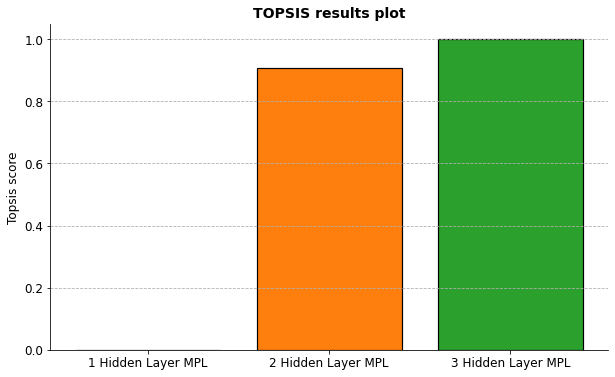

There is no intersection between interest and worst density.
There is no intersection between interest and intermediate density.
The 3 Hidden Layer MPL is greater than 2 Hidden Layer MPL for every value in range of analysis.
The 3 Hidden Layer MPL is greater than 1 Hidden Layer MPL for every value in range of analysis.


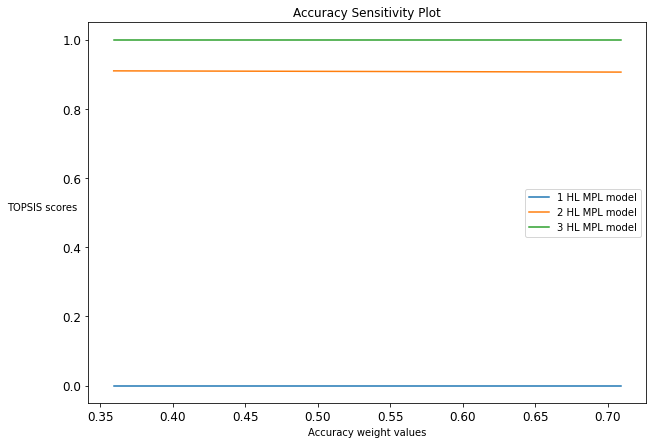

In [277]:
####  Accuracy   ###

# Import pair-wise comparison table for experts' preferences. 
df = pd.read_excel(r"C:\Users\...\weight_4.xlsx",
                      convert_float = False,index_col = "Unnamed: 0")  

# Save Fuzzy weights for this case
weights_4 = FuzzyAHP(df, "Accuracy")[1]

# Use TOPSIS to find the ideal solution in this case.
res = TOPSIS(df_C, weights_4, columns_positive_impact=(0,1,2,3), print_results=True, metric="Accuracy")

# Sensitivity analysis of AUC
scores = sensitivity_analysis(boundary = 0.2, metric = "Accuracy", df_1= df_C, weights = weights_4, columns_positive_impact=(0,1,2,3))